# 2d

In [3]:
from hyper_tuning_helper_functions import (
    model_mlp_2_classes,
    fit_then_evaluate_mlp_model
)
from load_datasets import create_generators

## Static feature extraction

In [4]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten

image_size = 299

train_generator_299x299, val_generator_299x299 = create_generators(
    (image_size, image_size)
)

Xception_model_global_avarage_pooling_output = Sequential(
    [
        Xception(
            weights="imagenet",
            include_top=False,
            input_shape=(image_size, image_size, 3),
        ),
        GlobalAveragePooling2D(),
    ]
)

Xception_model_flatten_output = Sequential(
    [
        Xception(
            weights="imagenet",
            include_top=False,
            input_shape=(image_size, image_size, 3),
        ),
        Flatten(),
    ]
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-11 14:21:13.484378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-11 14:21:13.484522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
X_train_feature_maps = Xception_model_global_avarage_pooling_output.predict(train_generator_299x299)

2022-05-11 14:21:15.397810: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-11 14:21:15.720765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [6]:
test_predict_generator = Xception_model_global_avarage_pooling_output.predict(train_generator_299x299)

In [7]:
test_predict_generator.shape

(1600, 2048)

In [8]:
import numpy as np

def extract_X_y_from_generator(generator):
    steps = generator.n//generator.batch_size
    X, y = [] , []
    for _ in range(steps):
        X_batch, y_batch = generator.next()
        X.extend(X_batch)
        y.extend(y_batch)
    return np.array(X), np.array(y)

def extract_feature_maps(model, generator):
    X, y = extract_X_y_from_generator(generator)
    return model.predict(X), y

In [9]:
X_train_avarage_pooling, y_train_avarage_pooling = extract_feature_maps(
    Xception_model_global_avarage_pooling_output, train_generator_299x299
)

X_val_avarage_pooling, y_val_avarage_pooling = extract_feature_maps(
    Xception_model_global_avarage_pooling_output, val_generator_299x299
)


X_train_flatten, y_train_flatten = extract_feature_maps(
    Xception_model_flatten_output, train_generator_299x299
)

X_val_flatten, y_val_flatten = extract_feature_maps(
    Xception_model_flatten_output, val_generator_299x299
)


X_train_avarage_pooling.shape, X_train_flatten.shape, X_val_avarage_pooling.shape, X_val_flatten.shape

2022-05-11 14:22:13.828209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 14:22:57.091364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 14:23:23.234155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


((1600, 2048), (1600, 204800), (384, 2048), (368, 204800))

## MLP Models

2022-05-11 14:30:28.805994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 14:30:29.158014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


val_acc: 0.9895833730697632


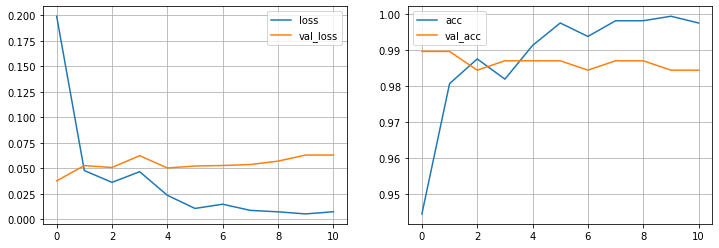

In [17]:
model_1__dense_dropout_pairs = [(512,0)]
model_1 = model_mlp_2_classes(model_1__dense_dropout_pairs, X_train_avarage_pooling.shape[1])
fit_then_evaluate_mlp_model(model_1, X_train_avarage_pooling, y_train_avarage_pooling, (X_val_avarage_pooling, y_val_avarage_pooling))

2022-05-11 14:25:37.749262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 14:25:44.116922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


val_acc: 0.989130437374115


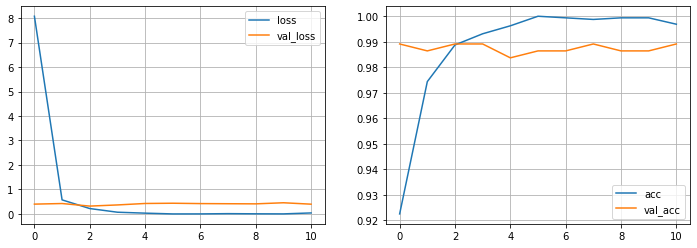

In [15]:
model_2 = model_mlp_2_classes(model_1__dense_dropout_pairs, X_train_flatten.shape[1])
fit_then_evaluate_mlp_model(model_2, X_train_flatten, y_train_flatten, (X_val_flatten, y_val_flatten))

In [20]:
model_1.summary()

Model: "transferacne_model_2_classes"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 1,049,601
Trainable params: 1,049,601
Non-trainable params: 0
_________________________________________________________________


2022-05-11 14:31:16.442827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 14:31:16.993736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


val_acc: 0.9921875


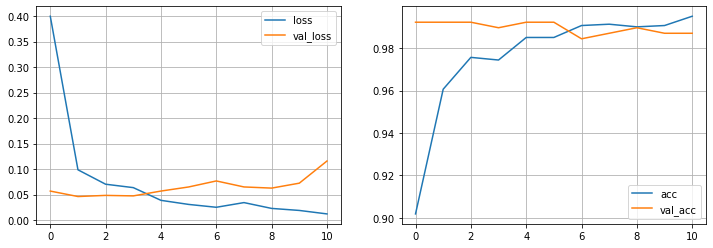

In [19]:
model_3__dense_dropout_pairs = [(1024, .3), (512, .3)]
model_3 = model_mlp_2_classes(model_3__dense_dropout_pairs, X_train_avarage_pooling.shape[1])
fit_then_evaluate_mlp_model(model_3, X_train_avarage_pooling, y_train_avarage_pooling, (X_val_avarage_pooling, y_val_avarage_pooling))

2022-05-11 14:32:03.633825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 14:32:04.226880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


val_acc: 0.9947916865348816


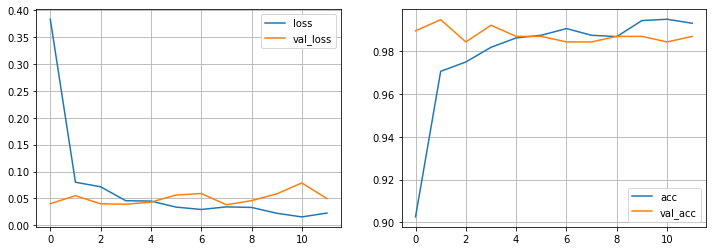

In [21]:
model_4__dense_dropout_pairs = [(1024, .3), (512, .3), (256, .3), (128, .3)]
model_4 = model_mlp_2_classes(model_4__dense_dropout_pairs, X_train_avarage_pooling.shape[1])
fit_then_evaluate_mlp_model(model_4, X_train_avarage_pooling, y_train_avarage_pooling, (X_val_avarage_pooling, y_val_avarage_pooling))

2022-05-11 14:35:43.437335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 14:35:45.241756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


val_acc: 0.9921875


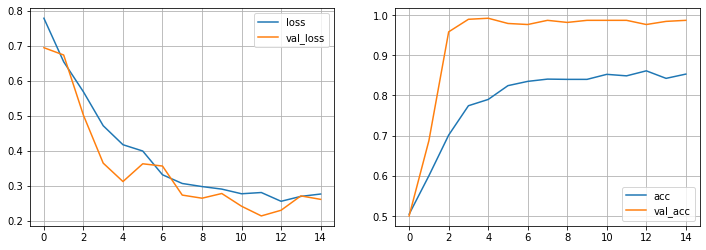

In [22]:
model_5__dense_dropout_pairs = [(1024, .3), (512, .3), (256, .3), (128, .3), (64, .3), (32, .3), (16, .3), (8, .3), (4, .3)]
model_5 = model_mlp_2_classes(model_5__dense_dropout_pairs, X_train_avarage_pooling.shape[1])
fit_then_evaluate_mlp_model(model_5, X_train_avarage_pooling, y_train_avarage_pooling, (X_val_avarage_pooling, y_val_avarage_pooling))

2022-05-11 14:37:49.638213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-11 14:37:50.911066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


val_acc: 0.9947916865348816


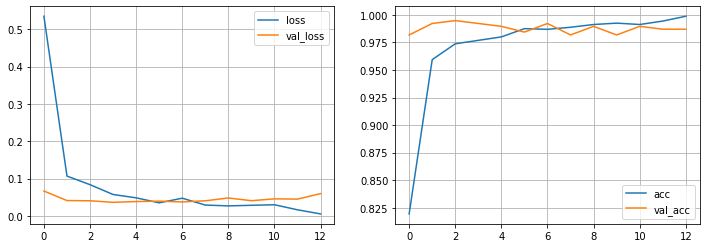

In [23]:
model_6__dense_dropout_pairs = [(1024, .3), (512, .3), (256, .3), (128, .3), (64, .3), (32, .3)]
model_6 = model_mlp_2_classes(model_6__dense_dropout_pairs, X_train_avarage_pooling.shape[1])
fit_then_evaluate_mlp_model(model_6, X_train_avarage_pooling, y_train_avarage_pooling, (X_val_avarage_pooling, y_val_avarage_pooling))

## Random Forest Model

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

decisiontreeclassifier = DecisionTreeClassifier()
randomforestclassifier = RandomForestClassifier()

In [24]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
def show_classification_evaluation_metrics(
    y_pred, y_test, display_labels=["True", "False"]
):
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred), display_labels=display_labels
    ).plot()

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       192
           1       0.97      0.98      0.97       192

    accuracy                           0.97       384
   macro avg       0.97      0.97      0.97       384
weighted avg       0.97      0.97      0.97       384



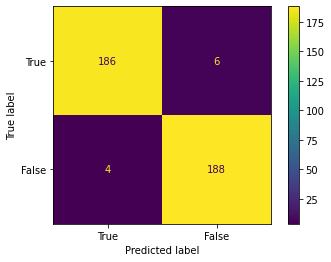

In [26]:
decisiontreeclassifier.fit(X_train_avarage_pooling, y_train_avarage_pooling)
y_pred = decisiontreeclassifier.predict(X_val_avarage_pooling)
show_classification_evaluation_metrics(y_pred, y_val_avarage_pooling)

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       184
           1       0.97      0.90      0.93       184

    accuracy                           0.93       368
   macro avg       0.94      0.93      0.93       368
weighted avg       0.94      0.93      0.93       368



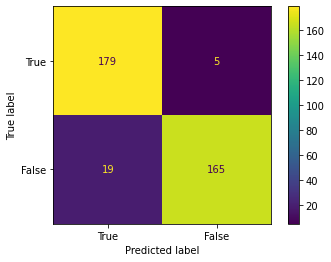

In [28]:
decisiontreeclassifier_2 = DecisionTreeClassifier()
decisiontreeclassifier_2.fit(X_train_flatten, y_train_flatten)
y_pred = decisiontreeclassifier_2.predict(X_val_flatten)
show_classification_evaluation_metrics(y_pred, y_val_flatten)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       192
           1       0.98      1.00      0.99       192

    accuracy                           0.99       384
   macro avg       0.99      0.99      0.99       384
weighted avg       0.99      0.99      0.99       384



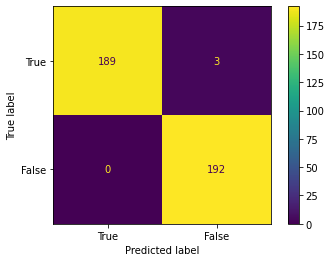

In [29]:
randomforestclassifier.fit(X_train_avarage_pooling, y_train_avarage_pooling)
y_pred = randomforestclassifier.predict(X_val_avarage_pooling)
show_classification_evaluation_metrics(y_pred, y_val_avarage_pooling)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       184
           1       0.98      1.00      0.99       184

    accuracy                           0.99       368
   macro avg       0.99      0.99      0.99       368
weighted avg       0.99      0.99      0.99       368



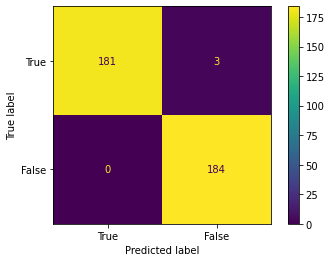

In [30]:
randomforestclassifier_2 = RandomForestClassifier()
randomforestclassifier_2.fit(X_train_flatten, y_train_flatten)
y_pred = randomforestclassifier_2.predict(X_val_flatten)
show_classification_evaluation_metrics(y_pred, y_val_flatten)

In [11]:
# TODO 5: testa använd random forest istället för mlp